# PREAMBLE

We will look at how to run MCMCs on data using **emcee**, a pure-Python implementation of an Markov chain Monte Carlo (MCMC) ensemble sampler (to be specific: Goodman & Weare’s Affine Invariant Markov chain Monte Carlo Ensemble sampler).

When a package is missing, this is how you can install it (on Colab, or machines supplied with `pip`).

If you have multiple `pip` commands available in your terminal (`pip`, `pip3`, `pip3.10`, etc.) make sure you invoke the one that matches the interpreter you are using with Jupyter.  To check the Python version you are using, run the following lines

In [1]:
from platform import python_version
print(python_version())

3.11.0


Back to installing possibly missing packages

In [2]:
#!pip install emcee

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import emcee

## Let's cook up some data to analyze

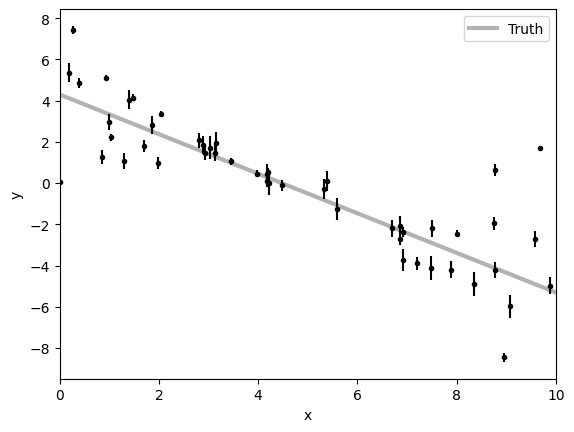

In [4]:
# Fixing the seed to make the random numbers reproducible
np.random.seed(1)

# Specify "truth": y = mx + q
m_true = -0.9594
q_true = 4.294
true_dict = {'m': m_true, 'q': q_true}

# Specify an amplitude for Gaussian noise
f_true = 0.534

# Generate some synthetic data from the "truth"
N = 50
x = np.sort(10 * np.random.rand(N))
y = m_true * x + q_true
# Generate the QUOTED (Gaussian) uncertainties on such data
yerr = 0.1 + 0.5 * np.random.rand(N)
# and polute the y's with these errors
y += yerr * np.random.randn(N)
# Ensure that these uncertainties understimate the actual ones
# by a constant fractional amount f_true * gaussian noise
y += np.abs(f_true * y) * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + q_true, "k", alpha=0.3, lw=3, label="Truth")
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

## Least-squared fit with `scipy.optimize.curve_fit`

In [5]:
def fitfunc(x, m, q):
    return m*x + q

param_labels = ['m', 'q']

fit_pars, cov_matrix = curve_fit(fitfunc, x, y, sigma=yerr)

for i in range(len(param_labels)):
    print("{0: .1f}% error on parameter {1}".format(np.abs(100*cov_matrix[i, i]**0.5/fit_pars[i]), param_labels[i]))
    print("{0: .4f} +/-{1: .4f} (true value {2})\n".format(fit_pars[i], cov_matrix[i, i]**0.5, true_dict[param_labels[i]]))

 19.9% error on parameter m
-0.5222 +/- 0.1038 (true value -0.9594)

 17.4% error on parameter q
 3.1797 +/- 0.5547 (true value 4.294)



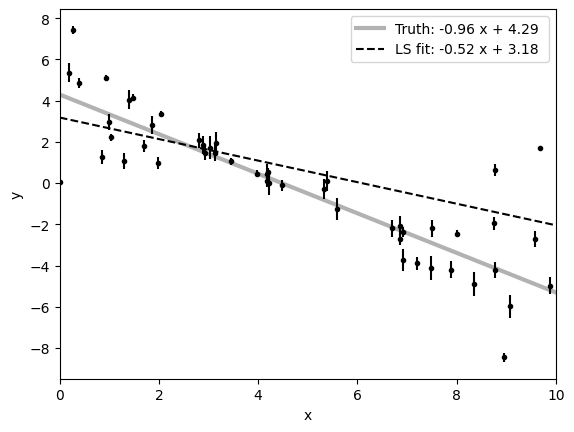

In [6]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + q_true, "k", alpha=0.3, lw=3, label="Truth: %.2f x + %.2f " % (m_true, q_true))
plt.plot(x0, fitfunc(x0, *fit_pars), '--k', label="LS fit: %.2f x + %.2f" % tuple(fit_pars))
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

The result is reasonable (notice how the cluster of data points affects it), but the uncertainties on the two parameters are small, because of the small error bars on most of the data points.

## Maximum likelihood estimation

The least squares solution is the maximum likelihood result for a model where the error bars are assumed to be:
1. correct,
1. Gaussian, and
1. independent.

But this is not the right model!  Additionally, there is no generalization of least squares that supports a model like the one that we know to be true. Instead, we need to write down the likelihood function and numerically optimize it.

`emcee` uses logarithms of probability densities, so we focus on the log-likelihood and write out a Gaussian with variance underestimated by some fractional amount $f$:
$$
\ln \mathcal{L}(\mathbf{d}|\boldsymbol{\theta}) = \ln p(\mathbf{x}, \mathbf{y}, \boldsymbol{\sigma}| m,q,f) = -{1\over 2}\sum_k\left[ {{(y_k - mx_k - q)^2}\over {s_k^2}} + \ln (2\pi s_k^2)\right]
$$
with
$$
s_k^2 = \sigma_k^2 + f^2(mx_k + q)^2\,.
$$

[Note that we can think of $\mathbf{x}$ and $\boldsymbol{\sigma}$ as information $\mathcal{I}$ here and write $\ln \mathcal{L}(\mathbf{d}|\boldsymbol{\theta}, \mathcal{I}) = \ln p(\mathbf{y}| \mathbf{x},  \boldsymbol{\sigma}, m,q,f)$.]


We build the log-likelihood Python function [see later for why $\ln f$ rather than $f$ is used as a variable].

In [11]:
def log_likelihood(theta, x, y, yerr):
    m, q, log_f = theta
    model = m * x + q
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

We *minimize* $-\ln\mathcal{L}(\mathbf{d}|\boldsymbol{\theta})$ with `scipy.optimize.minimize`

Success status: True
Optimization terminated successfully.
Maximum likelihood estimates:
m = -0.9440 (True: -0.9594)
q = 4.2449 (True: 4.2940)
f = 0.5055 (True: 0.5340)


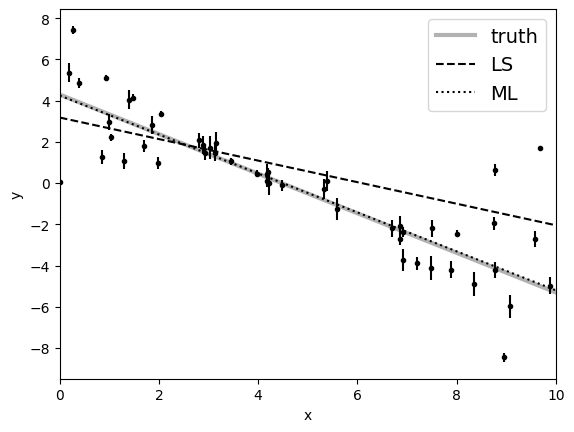

In [12]:
from scipy.optimize import minimize

# Reproducible results
np.random.seed(42)

# Function to minimize: the negative log-likelihood (nll)
nll = lambda *args: -log_likelihood(*args)

# Initial guess for the parameters (make it imperfect with Gaussian noise)
initial = np.array([m_true, q_true, np.log(f_true)]) + 0.1 * np.random.randn(3)

# Solve by minimization of -log-likelihood!
soln = minimize(nll, initial, args=(x, y, yerr))

# Check it converged
print("Success status:", soln.success)
print(soln.message)

# Extract maximum likelihood parameter values
m_ml, q_ml, log_f_ml = soln.x
print("Maximum likelihood estimates:")
print("m = {0:.4f} (True: {1:.4f})".format(m_ml, m_true))
print("q = {0:.4f} (True: {1:.4f})".format(q_ml, q_true))
print("f = {0:.4f} (True: {1:.4f})".format(np.exp(log_f_ml), f_true))

# Plot all together
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + q_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, fitfunc(x0, *fit_pars), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, q_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Much better, but how do we estimate the uncertainties on m and q?


Also, we do not really care much about the value of $f$ but it seems to propagate any uncertainties about its value to the final estimates of $m$ and $q$.

**This is where MCMC comes in.**



## MCMC estimation of model parameters via emcee

We would like to
1. be able to marginalize over "**nuisance parameters**" ($f$ in the example) and 
1. to find an estimate of the posterior probability function, i.e., the distribution of parameters that is consistent with the dataset, for the other parameters, i.e., the **model parameters**.

MCMC lets you do both of these things.

### 1. Set up the calculation
Let's write the **posterior probability distribution** in general terms:

$$
p(\boldsymbol{\theta}|\mathbf{d}) \propto \pi(\boldsymbol{\theta}) \mathcal{L}(\mathbf{d}|\boldsymbol{\theta})\,,
$$

where $\pi$ denotes the **prior probability distribution**.  For the case we are examining,

$$
p(m,q,f|\mathbf{x}, \mathbf{y}, \boldsymbol{\sigma}) \propto \pi(m,q,f)\mathcal{L}(\mathbf{x}, \mathbf{y}, \boldsymbol{\sigma}|m,q,f)\,.
$$

We have already written down the likelihood function, so what we are missing is the prior $p(m,q,f)$.  This function encodes any previous knowledge that we have about the parameters (e.g., results from other experiments, physically acceptable ranges, etc.).

The MCMC draws samples from a probability distribution.  We want that distribution to be a probability distribution for the parameters of interest, i.e., $\pi \times \mathcal{L}$.  For each draw, the likelihood will be evaluated and the product of the prior and likelihood yields the posterior (up to a constant, which is the **evidence**).

Let's pick a uniform, "uninformative" prior on $m$, $q$, and $\ln f$:

$$
p(m) =
\begin{cases}
1/5.5, & \textrm{if}~m\in (−5, 1/2)\\
0 & \textrm{otherwise}
\end{cases}
$$

$$
p(q) =
\begin{cases}
1/10, & \textrm{if}~q\in (0,10)\\
0 & \textrm{otherwise}
\end{cases}
$$

$$
p(\ln(f)) =
\begin{cases}
1/11, & \textrm{if}~\ln(f)\in (-10,1)\\
0 & \textrm{otherwise}
\end{cases}
$$

`emcee` **requires the logarithm of the probability density** one wants to sample, so here is the Python log-prior (up to a constant, which we set to 0 with the `return 0.0`):

In [13]:
def log_prior(theta):
    m, q, log_f = theta
    # Return a finite value if theta is in the parameter space region with support for the prior
    if -5.0 < m < 0.5 and 0.0 < q < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    # Otherwise return -infinity, basically a massive down-weight for the posterior
    return -np.inf

Combining this with the definition of `log_likelihood` we had above, the full log-probability function is:

In [14]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    # If theta is outside the support for the prior, return -infinity
    if not np.isfinite(lp):
        return -np.inf
    # Otherwise return the logarithm of prior*likelihood
    return lp + log_likelihood(theta, x, y, yerr)

### 2. Run the sampler

Now it is straightforward to sample this distribution using `emcee`.

Start by initializing the (32) walkers in a tiny Gaussian ball around the maximum likelihood result: this tends to be a pretty good initialization.

Then have the walkers perform their (5000) steps of MCMC in parallel and independently from one another.

In [15]:
# The number of walkers
nwalkers = 32

# The dimensionality of the parameter space (m, q, ln(f))
ndim = 3

# The MCMC steps
nmcmc = 5000

# Initial position
pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)

# Run the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, nmcmc, progress=True); # The ; avoids some prints to screen

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2588.27it/s]


### 3. Look at results

Let's inspect the `dir` of the `sampler` object returned by `emcee`.  It is always a good practice to do this when dealing with new objects one is not familiar with.

In [21]:
dir(sampler)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_moves',
 '_previous_state',
 '_random',
 '_weights',
 'acceptance_fraction',
 'acor',
 'backend',
 'blobs',
 'blobs_dtype',
 'chain',
 'compute_log_prob',
 'flatblobs',
 'flatchain',
 'flatlnprobability',
 'get_autocorr_time',
 'get_blobs',
 'get_chain',
 'get_last_sample',
 'get_log_prob',
 'get_value',
 'iteration',
 'lnprobability',
 'log_prob_fn',
 'ndim',
 'nwalkers',
 'params_are_named',
 'pool',
 'random_state',
 'reset',
 'run_mcmc',
 'sample',
 'vectorize']

To see what the sampler did, a good first step is to look at the time series of the parameters in the chain.  The samples can be accessed using the `EnsembleSampler.get_chain()` method.  This returns an array with the shape `(nmcmc, nwalkers, ndim)`, providing the parameter values for each walker at each step in the chain.

We will overlay all the chains.  If one wishes to plot a specific chain, say the first one, `samples[:, 0, i]` should be used in the code below, rather than `samples[:, :, i]`.

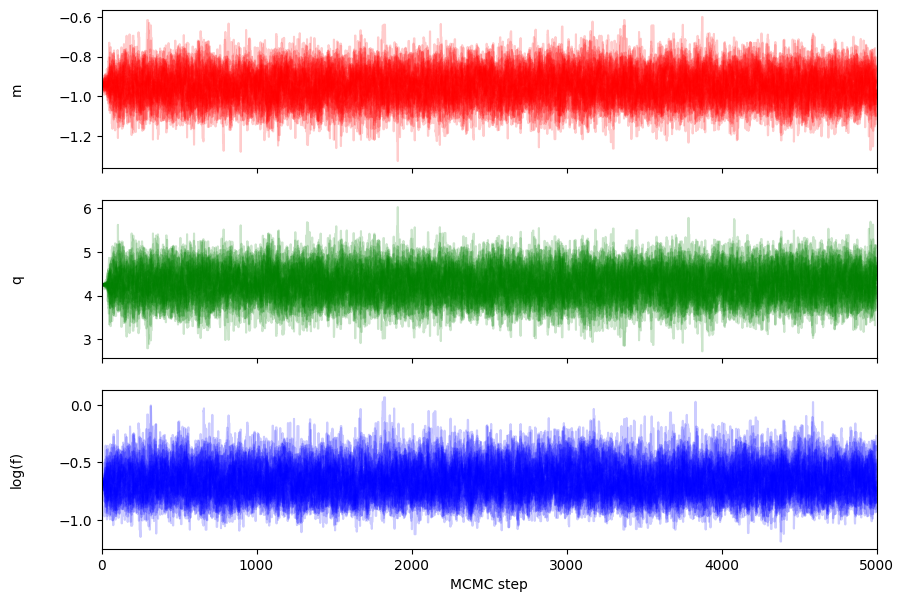

In [28]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "q", "log(f)"]
col = ['r', 'g', 'b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], col[i], alpha=0.2) # 
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("MCMC step"); # The ; avoids an unwanted output to screen.

The walkers start in small distributions around the maximum (log-)likelihood values and then wander and start exploring the full posterior distribution.

After fewer than 50 steps, the samples seem pretty well “burnt-in.”  It is hard to define this statement quantitatively, but an estimate of the integrated autocorrelation time

In [29]:
tau = sampler.get_autocorr_time()
print(tau)

[34.92700634 36.2361308  36.60970479]


suggests that $\sim 40$ steps are needed for the chain to “forget” where it started.  It is reasonable to throw away a few times this number of steps as “burn-in."

Let’s discard the initial 100 steps of each walker, *thin* (i.e., take strides) by about half the autocorrelation time (20 steps) for each walker, and flatten the chains so that we have a flat list of samples:

In [30]:
flat_samples = sampler.get_chain(discard=100, thin=20, flat=True)
print(flat_samples.shape)

(7840, 3)


Quick check of the number returned, according to the logic above:

In [35]:
int(nwalkers*(nmcmc - 100)/20)

7840

Now let’s make a [**corner plot**](https://corner.readthedocs.io/en/latest/), one of the most useful plots related to MCMC calculations:

In [36]:
#!pip install corner

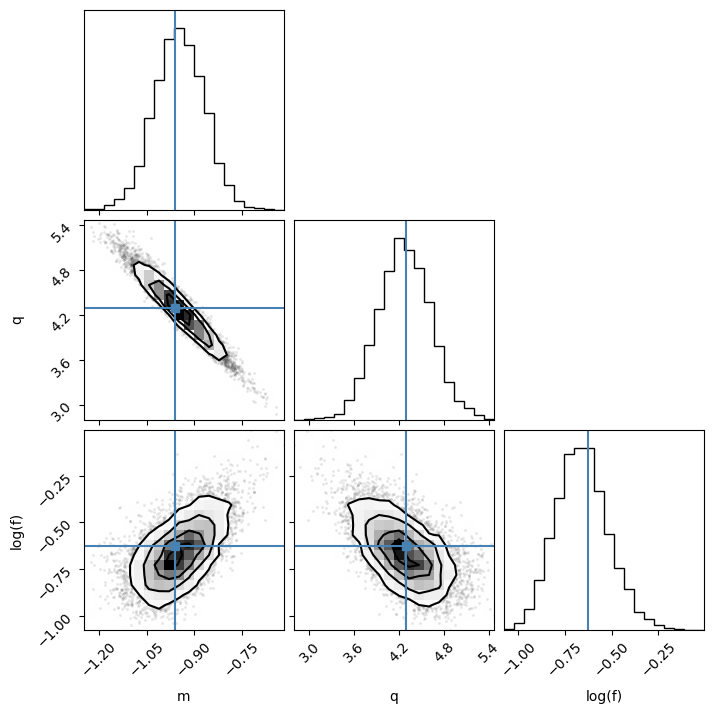

In [37]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=[m_true, q_true, np.log(f_true)])

These are **all the one and two dimensional projections of the posterior probability distributions** of the parameters we are inferring.  It quickly shows all of the covariances between parameters.

To find the marginalized distribution for a parameter or set of parameters using the results of the MCMC chain, one projects the samples into the sub-space of interest and then makes a histogram over it.  Corner plots are doing this in all possibile 2D and 1D sub-spaces.  They are numerically evaluating and displaying

$$
p(\theta_1|\mathbf{d}) = \int p(\theta_1, \theta_2, \ldots, \theta_N|\mathbf{d}) d\theta_2 d\theta_3 \ldots d\theta_N
$$

on the diagonals, and

$$
p(\theta_1, \theta_2|\mathbf{d}) = \int p(\theta_1, \theta_2, \ldots, \theta_N|\mathbf{d}) d\theta_3 d\theta_4 \ldots d\theta_N\,.
$$

off the diagonals.

Another diagnostic plot is the projection of the results into the space of the observed data. Choose a few (say 100 in this case) samples from the chain and plot them on top of the data points:

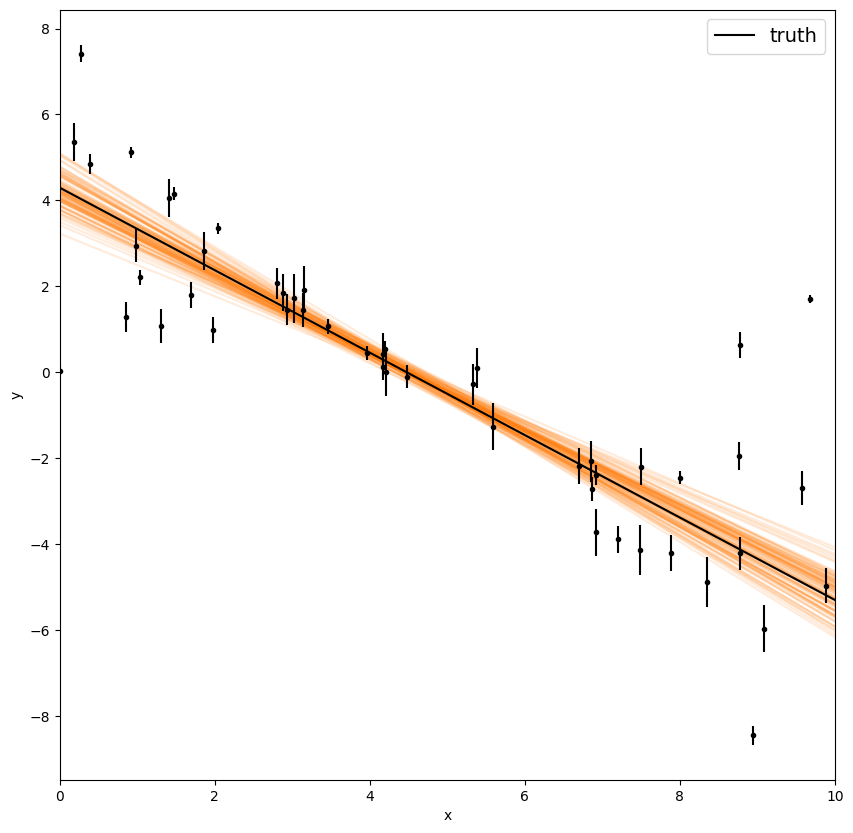

In [38]:
inds = np.random.randint(len(flat_samples), size=100)

fig = plt.figure(figsize=(10,10))
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.15)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + q_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Last but not least, the parameter values and their **credible intervals**.

Say you decide to quote the 90% credible intervals, with the median value.  You need the 5th, 50th, and 95th percentile of the samples in the marginalized distributions.

In [40]:
from IPython.display import display, Math

msg = "\mathrm{MCMC~results:}"
display(Math(msg))
txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
for i in range(ndim):
    ptile = np.percentile(flat_samples[:, i], [5, 50, 95])
    interval = np.diff(ptile)
    display(Math(txt.format(ptile[1], interval[0], interval[1], labels[i])))

print("\n")
msg = "\mathrm{As~a~reminder,~true~values~were:}"
display(Math(msg))
txt = "\mathrm{{{0}}} = {1:.4f}"
vals = [m_true, q_true, np.log(f_true)]
for i in range(len(vals)):
    display(Math(txt.format(labels[i], vals[i])))

print("\n")
msg = "\mathrm{As~a~reminder,~maximum~likelihood~estimates~were:}"
display(Math(msg))
txt = "\mathrm{{{0}}} = {1:.4f}"
vals = [m_ml, q_ml, log_f_ml]
for i in range(len(vals)):
    display(Math(txt.format(labels[i], vals[i])))

print("\n")   
msg = "\mathrm{As~a~reminder,~least-squares~values~were:}"
display(Math(msg))
txt = "\mathrm{{{0}}} = {1: .4f} \pm {2: .4f}"
for i in range(len(fit_pars)):
    display(Math(txt.format(labels[i], fit_pars[i], cov_matrix[i, i]**0.5)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>